In [1]:
%load_ext watermark


In [2]:
import itertools as it
import os

from downstream import dstream
import matplotlib as mpl
import more_itertools as mit
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp

import pylib  # noqa: F401


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-02-24T02:35:57.775108+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.5.0-1025-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

seaborn       : 0.13.2
pylib         : 0.0.0
teeplot       : 1.4.2
polars        : 1.9.0
more_itertools: 9.1.0
downstream    : 1.6.2
matplotlib    : 3.10.0

Watermark: 2.4.3



In [4]:
tp.save[".pgf"] = True
teeplot_subdir = os.environ.get(
    "NOTEBOOK_NAME", "2024-10-20-qos-dstream-vs-naive-tilted"
)
teeplot_subdir


'2025-01-18-qos-dstream-vs-naive-tilted'

In [5]:
buffer_size = 64
num_items = 10_000


## Define


In [6]:
def calc_qos_from_segment_lengths(segment_lengths: list[int]) -> float:
    segment_total = sum(segment_lengths)
    return max(
        (segment_length - 1) / ((segment_total - cumulative) or 1)
        for cumulative, segment_length in zip(
            it.accumulate([0, *segment_lengths]),
            [*segment_lengths, 1],
        )
    )


In [7]:
def calc_max_gaps_naive_doubling_tilted(
    buffer_size: int, num_ingests: int
) -> list[int]:
    segment_lengths = []
    max_gaps = [0]
    for i in range(num_ingests):

        if (len(segment_lengths) == buffer_size):
            segment_lengths = [
                a + b
                for a, b in mit.batched(segment_lengths, 2)
            ]
        segment_lengths.append(1)

        assert sum(segment_lengths) == i + 1
        max_gaps.append(calc_qos_from_segment_lengths(segment_lengths))

    return max_gaps[:-1]


In [8]:
def calc_max_gaps_dstream(buffer_size: int, num_items: int) -> list[int]:
    return [
        calc_qos_from_segment_lengths(
            [b - a for a, b in mit.pairwise(
            sorted(
                dstream.tilted_algo.lookup_ingest_times_eager(
                    buffer_size, i + 1
                ),
            ))],
        )
        if i >= buffer_size
        else 0
        for i in range(num_items)
    ]


## Example Plot


In [9]:
df = pl.concat(
    [
        pl.DataFrame(
            {
                "Algorithm": "naive tilted",
                "Gap Size Cost": calc_max_gaps_naive_doubling_tilted(
                    buffer_size, num_items
                ),
                "Num Items Ingested": range(num_items),
            },
            strict=False,
        ),
        pl.DataFrame(
            {
                "Algorithm": "dstream tilted",
                "Gap Size Cost": calc_max_gaps_dstream(
                    buffer_size, num_items
                ),
                "Num Items Ingested": range(num_items),
            },
            strict=False,
        ),
    ],
)


teeplots/2025-01-18-qos-dstream-vs-naive-tilted/hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.pgf
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.png


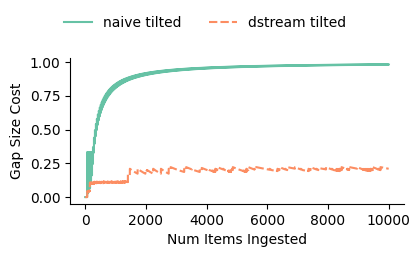

teeplots/2025-01-18-qos-dstream-vs-naive-tilted/font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.pgf
teeplots/2025-01-18-qos-dstream-vs-naive-tilted/font.family=serif+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+ext=.png


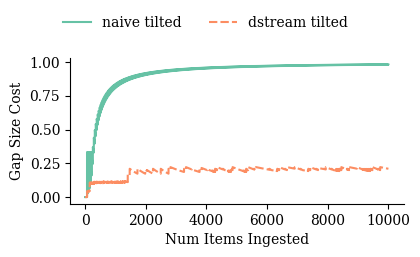

In [10]:
for rc in [{}, {"font.family": "serif"}]:
    with mpl.rc_context(rc=rc):
        with tp.teed(
            sns.relplot,
            df,
            x="Num Items Ingested",
            y="Gap Size Cost",
            hue="Algorithm",
            style="Algorithm",
            aspect=2,
            kind="line",
            height=2.2,
            palette="Set2",
            teeplot_outattrs=rc,
            teeplot_subdir=teeplot_subdir,
        ) as g:
            sns.move_legend(
                g,
                "lower center",
                bbox_to_anchor=(0.4, 1),
                ncol=2,
                title=None,
                frameon=False,
            )
